# Projet Datascientest - Compagnon immo

<code>mar25_bds_compagnon_immo_1</code>

---

## Modélisation évolution des prix - v7.0

---

### Recherche optimisation R2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Bidirectional, GRU, LSTM, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D,  Layer
from tensorflow.keras.layers import Activation

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### Chargement des données nettoyées

In [2]:
output_path = '../data/processed/dep_75_cleaned.csv.gz'
df_dep = pd.read_csv(output_path, low_memory=False, index_col='date_mutation', parse_dates=True)

#### Ajout du taux d'inflation annuel, taux livret A et taux moyen bancaire

In [5]:
# Source INSEE
df_inflation = pd.read_csv('../data/raw/inflation-2020-2024.csv', index_col=0)

df_inflation = df_inflation.drop('mois',axis=1)
df_inflation.rename(columns={'index': 'mois'}, inplace=True)
df_inflation.columns = df_inflation.columns.astype(int)
df_inflation["mois"] = df_inflation.index.astype(int)

def get_inflation(row):
    mois = row['mois']
    annee = row['annee']
    try:
        return df_inflation.loc[mois, annee]
    except KeyError:
        return np.nan

df_dep['taux_inflation'] = df_dep.apply(get_inflation, axis=1)

# Source Banque de France
taux_livret_a = {
     2020: 0.50,
     2021: 0.50,
     2022: 1.38,
     2023: 2.50,
     2024: 3.00,
}
taux_moyen_bancaire = {
     2020: 0.48,
     2021: 0.47,
     2022: 0.78,
     2023: 1.37,
     2024: 1.80,
}
df_dep["taux_livret_a"] = df_dep["annee"].map(taux_livret_a)
df_dep["taux_moyen_bancaire"] = df_dep["annee"].map(taux_moyen_bancaire)

In [7]:
df_dep = df_dep[df_dep['prix_m2_vente'] < 1_000_000]
df_dep = df_dep.drop([
    'numero_disposition', 
    'lot2_numero', 
    'lot2_surface_carrez',
    'lot3_numero', 
    'lot3_surface_carrez',
    'lot4_numero', 
    'lot4_surface_carrez', 
    'lot5_numero', 
    'lot5_surface_carrez'], axis=1)
df_dep.sample(5)

,nature_mutation,valeur_fonciere,code_commune,code_departement,lot1_numero,lot1_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,...,code_nature_culture_speciale,surface_terrain,longitude,latitude,prix_m2_vente,annee,mois,taux_inflation,taux_livret_a,taux_moyen_bancaire
date_mutation,,,,,,,,,,,,,,,,,,,,,
2021-12-22,Vente,80100000.0,75109,75,0,0.0,0,4.0,Local industriel. commercial ou assimilé,419.0,...,NS,599.0,2.327191,48.872900,191169.451074,2021,12,2.8,0.5,0.47
2020-12-04,Vente,5050000.0,75110,75,0,0.0,0,2.0,Appartement,42.0,...,NS,202.0,2.371224,48.871148,120238.095238,2020,12,0.0,0.5,0.48
2021-07-28,Vente,4660000.0,75120,75,0,0.0,0,4.0,Local industriel. commercial ou assimilé,35.0,...,NS,255.0,2.405872,48.852512,133142.857143,2021,7,1.2,0.5,0.47
2023-11-24,Vente,4300000.0,75117,75,0,0.0,0,3.0,Dépendance,0.0,...,NS,288.0,2.322517,48.887048,14930.555556,2023,11,3.5,2.5,1.37
2024-09-27,Vente,17352000.0,75107,75,0,0.0,0,3.0,Dépendance,0.0,...,NS,337.0,2.323489,48.853812,51489.614243,2024,9,1.1,3.0,1.80


In [9]:
df_dep = df_dep[df_dep['prix_m2_vente'] < 1_000_000]

In [11]:
df_dep['year_month'] = df_dep.index.to_period('M')

In [13]:
monthly_prices = df_dep.groupby('year_month')['prix_m2_vente'].mean()
monthly_prices.index = pd.PeriodIndex(monthly_prices.index)
monthly_prices = monthly_prices.sort_index()
monthly_prices.index = monthly_prices.index.to_timestamp()

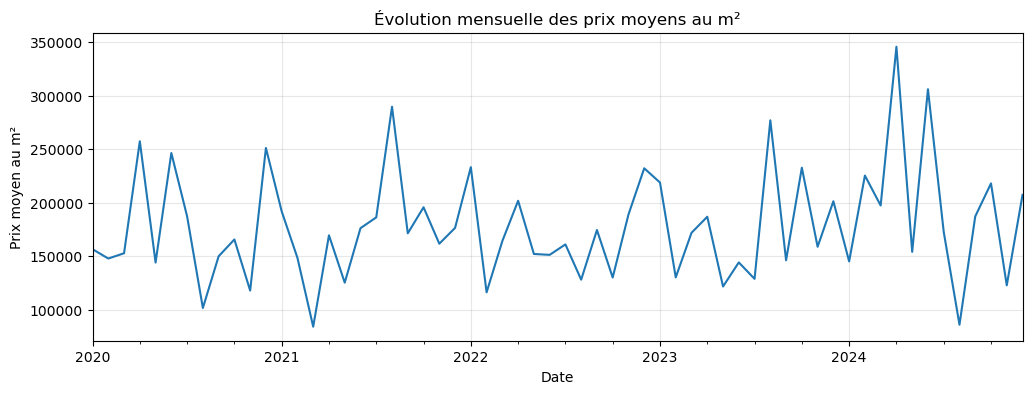

In [15]:
plt.figure(figsize=(12, 4))
monthly_prices.plot()
plt.title('Évolution mensuelle des prix moyens au m²')
plt.xlabel('Date')
plt.ylabel('Prix moyen au m²')
plt.grid(True, alpha=0.3)
plt.show()

### Analyse de la Stationnarité

In [68]:
def test_stationarity(timeseries):
    # Test Dickey-Fuller
    print('Résultats du test de stationnarité Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(
        dftest[0:4],
        index=['Statistique de test', 'p-value', 'Lags utilisés', 'Nombre d\'observations']
    )
    
    for key, value in dftest[4].items():
        dfoutput[f'Valeur critique ({key})'] = value
    
    print(dfoutput)
    
    # Interprétation
    if dftest[1] <= 0.05:
        print("Conclusion: La série est stationnaire (rejet de l'hypothèse nulle)")
    else:
        print("Conclusion: La série n'est pas stationnaire (non-rejet de l'hypothèse nulle)")

In [70]:
test_stationarity(monthly_prices)

Résultats du test de stationnarité Dickey-Fuller:
Statistique de test     -8.596278e+00
p-value                  7.063484e-14
Lags utilisés            0.000000e+00
Nombre d'observations    5.900000e+01
Valeur critique (1%)    -3.546395e+00
Valeur critique (5%)    -2.911939e+00
Valeur critique (10%)   -2.593652e+00
dtype: float64
Conclusion: La série est stationnaire (rejet de l'hypothèse nulle)


In [72]:
decomposition = seasonal_decompose(monthly_prices, model='additive', period=12)

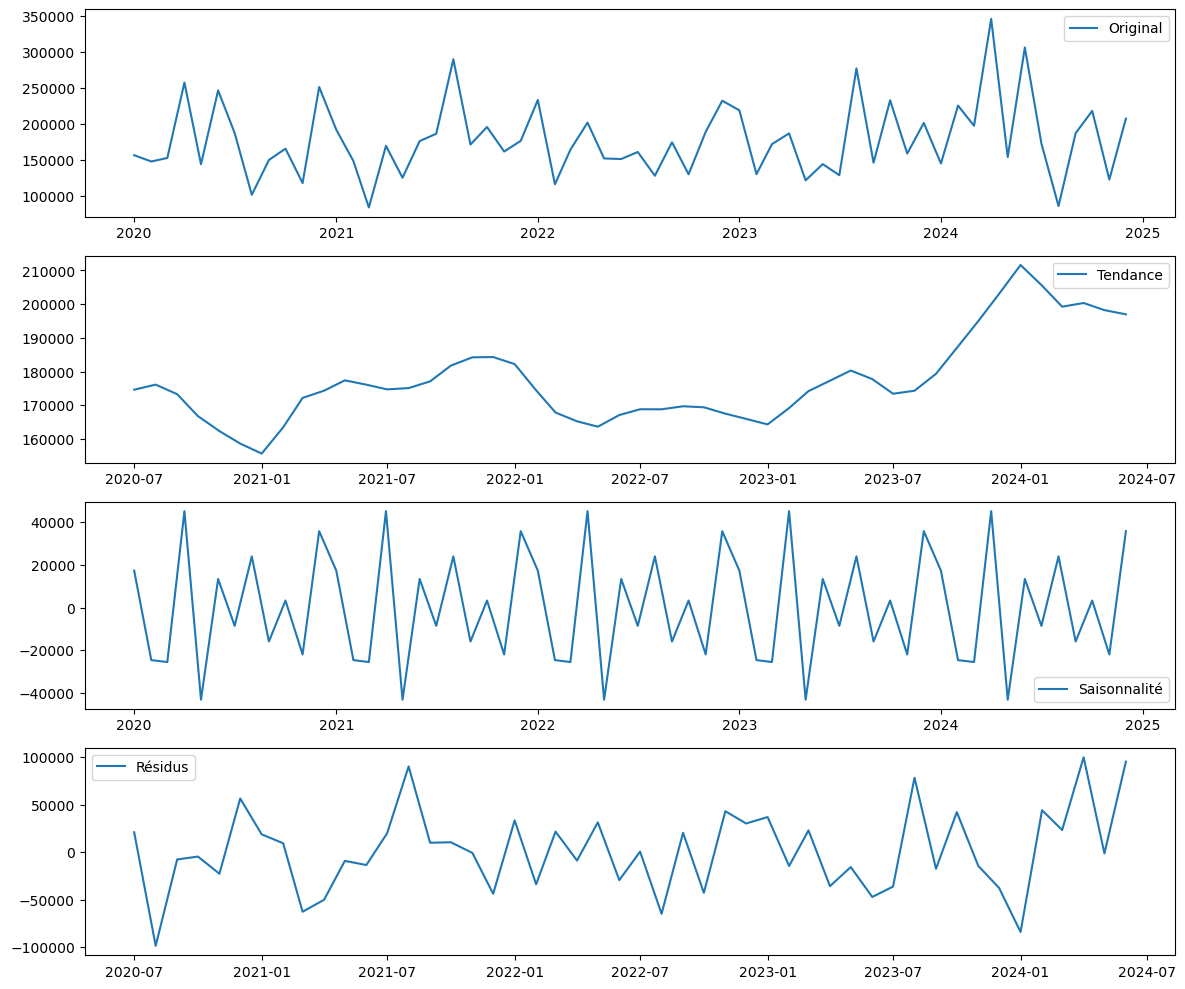

In [74]:
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(monthly_prices, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Tendance')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Saisonnalité')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Résidus')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Analyse ACF et PACF

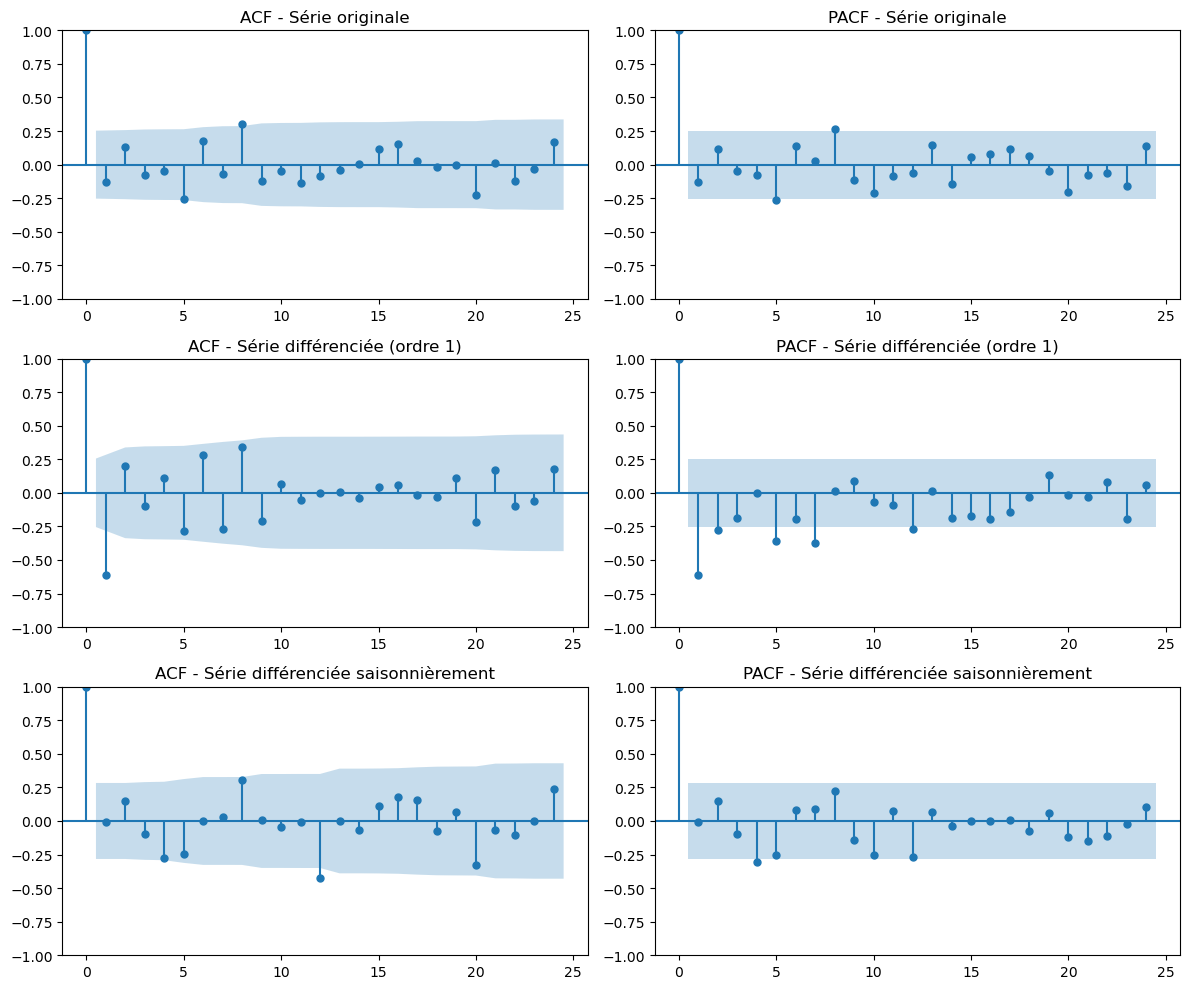

In [21]:
monthly_prices_diff = monthly_prices.diff().dropna()
monthly_prices_seasonal_diff = monthly_prices.diff(12).dropna()
lags = 24
plt.figure(figsize=(12, 10))
plt.subplot(321)
plot_acf(monthly_prices, lags=lags, ax=plt.gca(), title='ACF - Série originale')

plt.subplot(322)
plot_pacf(monthly_prices, lags=lags, ax=plt.gca(), title='PACF - Série originale')

plt.subplot(323)
plot_acf(monthly_prices_diff, lags=lags, ax=plt.gca(), title='ACF - Série différenciée (ordre 1)')

plt.subplot(324)
plot_pacf(monthly_prices_diff, lags=lags, ax=plt.gca(), title='PACF - Série différenciée (ordre 1)')

plt.subplot(325)
plot_acf(monthly_prices_seasonal_diff, lags=lags, ax=plt.gca(), title='ACF - Série différenciée saisonnièrement')

plt.subplot(326)
plot_pacf(monthly_prices_seasonal_diff, lags=lags, ax=plt.gca(), title='PACF - Série différenciée saisonnièrement')

plt.tight_layout()
plt.show()

### Modélisation avec ARIMA

Taille de l'ensemble d'entraînement: 48
Taille de l'ensemble de test: 12
                                     SARIMAX Results                                      
Dep. Variable:                      prix_m2_vente   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -413.063
Date:                            Fri, 23 May 2025   AIC                            836.126
Time:                                    17:07:31   BIC                            843.757
Sample:                                01-01-2020   HQIC                           838.728
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0029      0.008    128.7

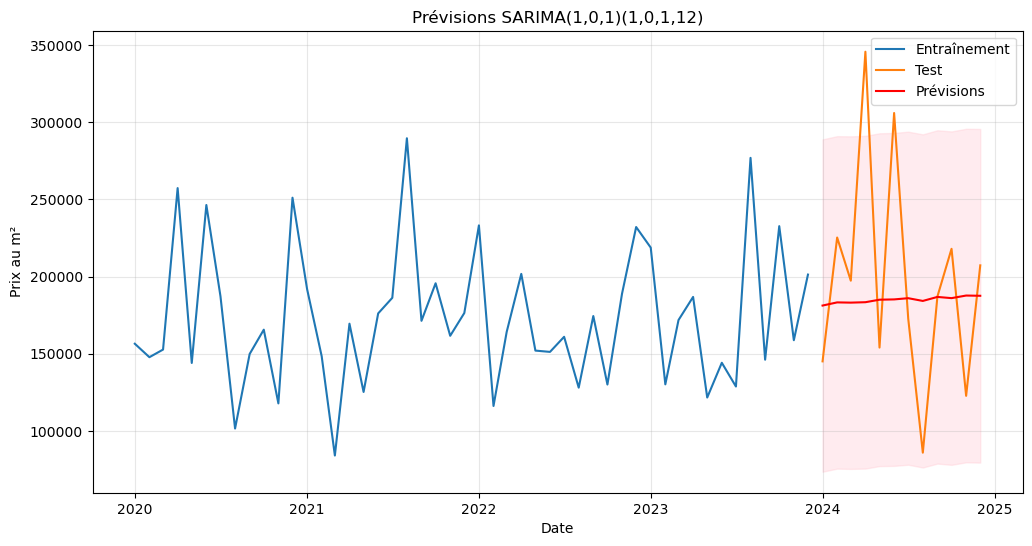


Évaluation du modèle SARIMA:
MAE: 52907.83
RMSE: 71071.92
R2: -0.04
SARIMA(0,0,0)(0,0,0,12) - MAE: 197228.41
SARIMA(0,0,0)(0,0,1,12) - MAE: 197228.41
SARIMA(0,0,0)(0,1,0,12) - MAE: 73318.55
SARIMA(0,0,0)(0,1,1,12) - MAE: 68705.84
SARIMA(0,0,0)(1,0,0,12) - MAE: 75058.29
SARIMA(0,0,0)(1,0,1,12) - MAE: 66504.88
SARIMA(0,0,0)(1,1,0,12) - MAE: 66334.75
SARIMA(0,0,0)(1,1,1,12) - MAE: 65996.68
SARIMA(0,0,1)(0,0,0,12) - MAE: 187029.38
SARIMA(0,0,1)(0,0,1,12) - MAE: 201571.78
SARIMA(0,0,1)(0,1,0,12) - MAE: 73359.01
SARIMA(0,0,1)(0,1,1,12) - MAE: 68724.21
SARIMA(0,0,1)(1,0,0,12) - MAE: 75465.75
SARIMA(0,0,1)(1,0,1,12) - MAE: 65147.15
SARIMA(0,0,1)(1,1,0,12) - MAE: 66383.11
SARIMA(0,0,1)(1,1,1,12) - MAE: 66042.66
SARIMA(0,0,2)(0,0,0,12) - MAE: 186321.05
SARIMA(0,0,2)(0,0,1,12) - MAE: 6203767066222361.00
SARIMA(0,0,2)(0,1,0,12) - MAE: 74425.60
SARIMA(0,0,2)(0,1,1,12) - MAE: 69459.88
SARIMA(0,0,2)(1,0,0,12) - MAE: 80180.10
SARIMA(0,0,2)(1,0,1,12) - MAE: 66409.86
SARIMA(0,0,2)(1,1,0,12) - MAE: 6670

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Division des données en ensembles d'entraînement et de test
train_size = int(len(monthly_prices) * 0.8)
train, test = monthly_prices[:train_size], monthly_prices[train_size:]

print(f"Taille de l'ensemble d'entraînement: {len(train)}")
print(f"Taille de l'ensemble de test: {len(test)}")

# Fonction pour évaluer les modèles
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
 
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")
    
    return mae, rmse, r2

p, d, q = 1, 0, 1  # Paramètres non saisonniers
P, D, Q, s = 1, 0, 1, 12  # Paramètres saisonniers

# Entraînement du modèle
model = SARIMAX(
    train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

# Prévisions sur l'ensemble de test
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Visualisation des prévisions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entraînement')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_mean.index, forecast_mean, label='Prévisions', color='red')
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title(f'Prévisions SARIMA({p},{d},{q})({P},{D},{Q},{s})')
plt.xlabel('Date')
plt.ylabel('Prix au m²')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Évaluation du modèle
print("\nÉvaluation du modèle SARIMA:")
evaluate_model(test, forecast_mean)

# Recherche automatique des meilleurs paramètres
def sarima_grid_search(train, test):
    best_score = float('inf')
    best_params = None
    best_model = None
    
    p_values = range(0, 3)
    d_values = range(0, 2)
    q_values = range(0, 3)
    P_values = range(0, 2)
    D_values = range(0, 2)
    Q_values = range(0, 2)
    s_values = [12]  # Période saisonnière (mensuelle)
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for s in s_values:
                                try:
                                    model = SARIMAX(
                                        train,
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, s),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                    )
                                    
                                    results = model.fit(disp=False)
                                    forecast = results.get_forecast(steps=len(test))
                                    forecast_mean = forecast.predicted_mean
                                    
                                    mae = mean_absolute_error(test, forecast_mean)
                                    
                                    if mae < best_score:
                                        best_score = mae
                                        best_params = (p, d, q, P, D, Q, s)
                                        best_model = results
                                    
                                    print(f"SARIMA({p},{d},{q})({P},{D},{Q},{s}) - MAE: {mae:.2f}")
                                    
                                except:
                                    continue
    
    return best_params, best_model, best_score

# Recherche des meilleurs paramètres
best_params, best_model, best_score = sarima_grid_search(train, test)
print(f"\nMeilleurs paramètres: SARIMA{best_params} avec MAE: {best_score:.2f}")

### Modélisation avec Prophet

17:11:32 - cmdstanpy - INFO - Chain [1] start processing
17:11:32 - cmdstanpy - INFO - Chain [1] done processing


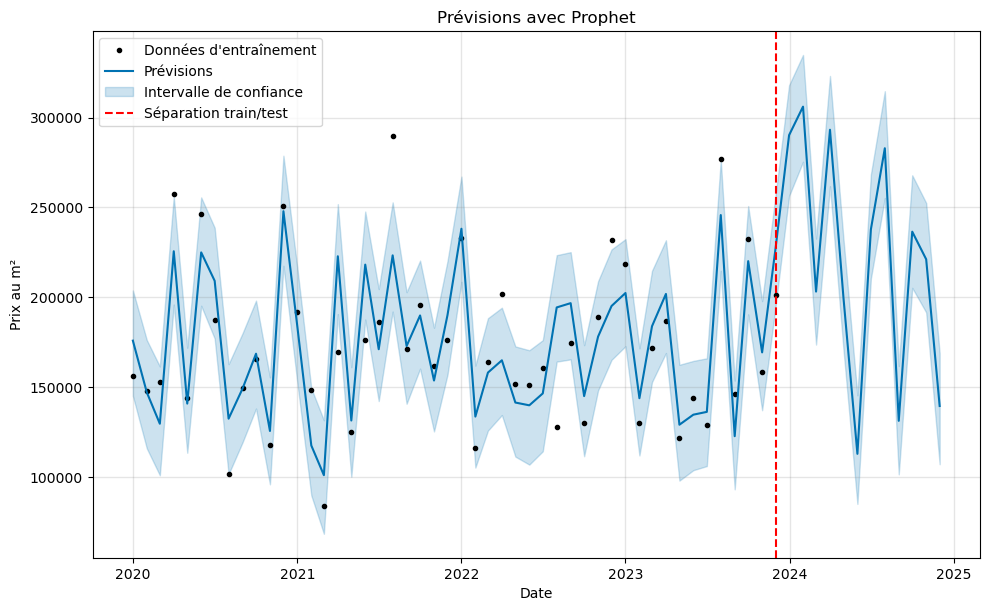

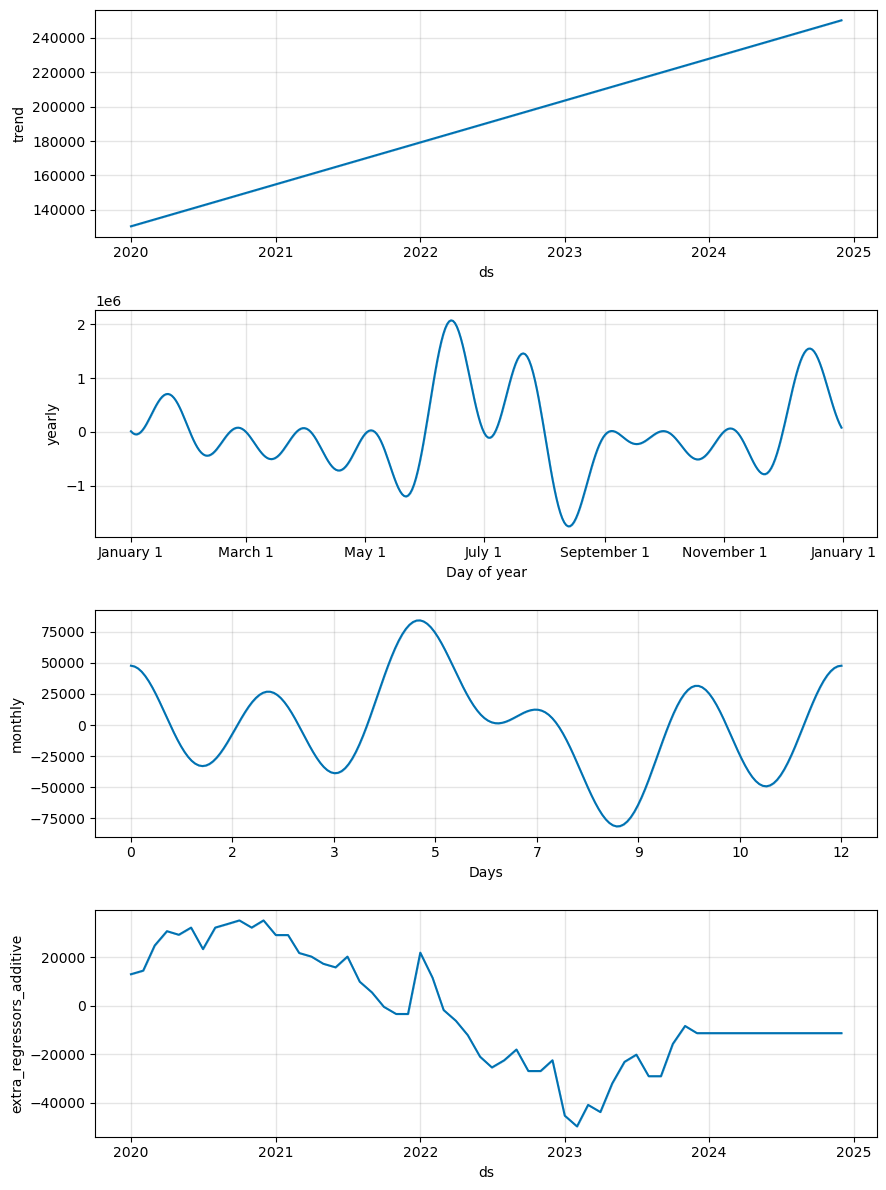


Évaluation du modèle Prophet:
MAE: 85461.60
RMSE: 104281.40
R2: -1.23


(85461.60280219307, 104281.40063665801, -1.2345103729342135)

In [32]:
prophet_data = monthly_prices.reset_index()
prophet_data.columns = ['ds', 'y']

train_prophet = prophet_data.iloc[:train_size]
test_prophet = prophet_data.iloc[train_size:]

model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)

model_prophet.add_seasonality(name='monthly', period=12, fourier_order=5)


if 'taux_inflation' in df_dep.columns and 'taux_livret_a' in df_dep.columns:
    regressors = df_dep[['taux_inflation', 'taux_livret_a', 'taux_moyen_bancaire']].resample('MS').mean()
    regressors = regressors.reset_index()
    regressors.columns = ['ds', 'taux_inflation', 'taux_livret_a', 'taux_moyen_bancaire']
    
    prophet_data_with_regressors = pd.merge(prophet_data, regressors, on='ds', how='left')
    
    prophet_data_with_regressors = prophet_data_with_regressors.fillna(method='ffill')
    
    train_prophet = prophet_data_with_regressors.iloc[:train_size]
    test_prophet = prophet_data_with_regressors.iloc[train_size:]
    
    model_prophet.add_regressor('taux_inflation')
    model_prophet.add_regressor('taux_livret_a')
    model_prophet.add_regressor('taux_moyen_bancaire')

model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='M')

# Ajout des régresseurs pour les prévisions futures
if 'taux_inflation' in df_dep.columns and 'taux_livret_a' in df_dep.columns:
    future = pd.merge(future, prophet_data_with_regressors[['ds', 'taux_inflation', 'taux_livret_a', 'taux_moyen_bancaire']], 
                     on='ds', how='left')
    future = future.fillna(method='ffill')

forecast_prophet = model_prophet.predict(future)

fig = model_prophet.plot(forecast_prophet)
plt.title('Prévisions avec Prophet')
plt.xlabel('Date')
plt.ylabel('Prix au m²')
plt.axvline(x=train_prophet['ds'].iloc[-1], color='r', linestyle='--')
plt.legend(['Données d\'entraînement', 'Prévisions', 'Intervalle de confiance', 'Séparation train/test'])
plt.show()

fig = model_prophet.plot_components(forecast_prophet)
plt.show()

prophet_predictions = forecast_prophet.iloc[train_size:][['ds', 'yhat']]
prophet_predictions = prophet_predictions.set_index('ds')
prophet_predictions.index = pd.to_datetime(prophet_predictions.index)

print("\nÉvaluation du modèle Prophet:")
evaluate_model(test, prophet_predictions['yhat'])

In [17]:
def encode_df(X_train, X_test):
    one_hot_cols = ['type_local', 'nature_mutation']
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe.fit(X_train[one_hot_cols])
    
    X_train_ohe = pd.DataFrame(ohe.transform(X_train[one_hot_cols]), 
                               columns=ohe.get_feature_names_out(one_hot_cols),
                               index=X_train.index)
    
    X_test_ohe = pd.DataFrame(ohe.transform(X_test[one_hot_cols]), 
                              columns=ohe.get_feature_names_out(one_hot_cols),
                              index=X_test.index)
    
    X_train = X_train.drop(columns=one_hot_cols)
    X_test = X_test.drop(columns=one_hot_cols)
    
    X_train = pd.concat([X_train, X_train_ohe], axis=1)
    X_test = pd.concat([X_test, X_test_ohe], axis=1)
    
    freq_cols = ['code_nature_culture', 'code_nature_culture_speciale', 'code_commune', 'code_departement']
    
    for col in freq_cols:
        freq_encoding = X_train[col].value_counts(normalize=True)
    
        X_train[col] = X_train[col].map(freq_encoding).fillna(0)
        X_test[col] = X_test[col].map(freq_encoding).fillna(0)
    
    
    X_train['lot1_numero'] = (X_train['lot1_numero'] != 0).astype(int)
    X_test['lot1_numero'] = (X_test['lot1_numero'] != 0).astype(int)
    
    return X_train, X_test

### Modélisation avec Deep Learning (LSTM)

Forme de X_train: (38, 12, 1)
Forme de y_train: (38, 1)
Forme de X_test: (10, 12, 1)
Forme de y_test: (10, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1302 - val_loss: 0.1712
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1098 - val_loss: 0.1483
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0926 - val_loss: 0.1268
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0767 - val_loss: 0.1067
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0595 - val_loss: 0.0879
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0463 - val_loss: 0.0708
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0378 - val_loss: 0.0560
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0284 - val_loss: 0.0448
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0286 - val_loss: 0.0383
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0321 - val_loss: 0.0366
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0366 - val_loss: 0.0370
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0384 - val_loss

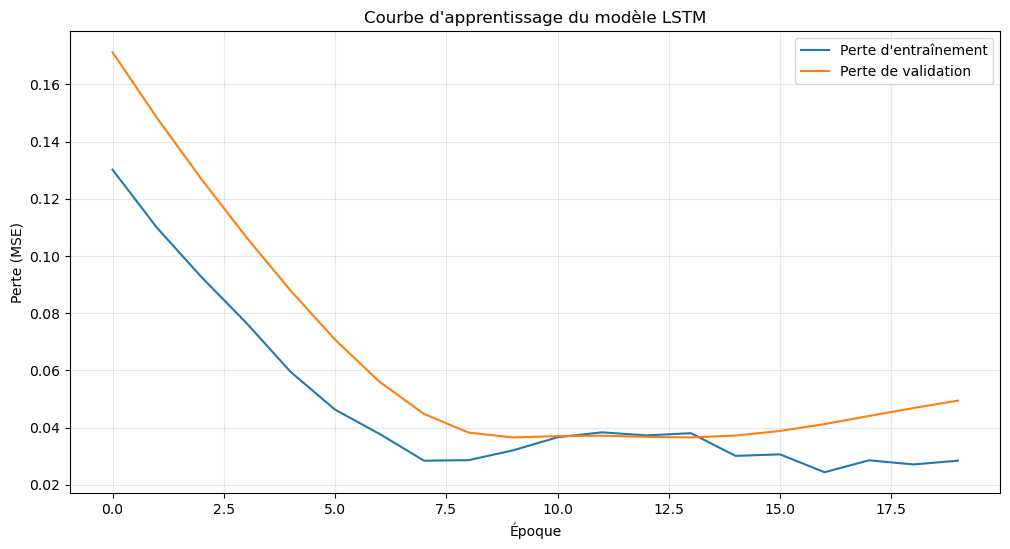

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


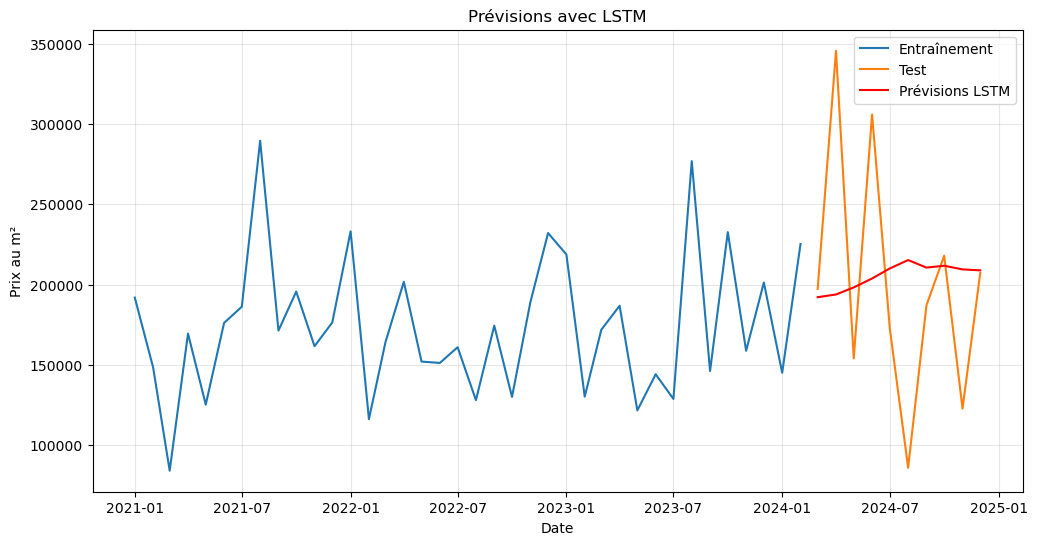


Évaluation du modèle LSTM:
MAE: 58812.55
RMSE: 78552.92
MAPE: 36.77%


(58812.548218628355, 78552.92074594491, 36.773136906690205)

In [169]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Fonction pour créer des séquences temporelles
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Préparation des données
# Nous utilisons uniquement la série temporelle des prix
data = monthly_prices.values.reshape(-1, 1)

# Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Création des séquences
seq_length = 12  # Utilisation des 12 derniers mois pour prédire le mois suivant
X, y = create_sequences(data_scaled, seq_length)

# Division en ensembles d'entraînement et de test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Forme de X_train: {X_train.shape}")
print(f"Forme de y_train: {y_train.shape}")
print(f"Forme de X_test: {X_test.shape}")
print(f"Forme de y_test: {y_test.shape}")

# Création du modèle LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Entraînement du modèle
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Visualisation de la courbe d'apprentissage
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Courbe d\'apprentissage du modèle LSTM')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Prévisions
y_pred_scaled = model.predict(X_test)

# Inverse de la normalisation
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)

# Visualisation des prévisions
plt.figure(figsize=(12, 6))
plt.plot(monthly_prices.index[seq_length:train_size+seq_length], scaler.inverse_transform(y_train), label='Entraînement')
plt.plot(monthly_prices.index[train_size+seq_length:], y_test_actual, label='Test')
plt.plot(monthly_prices.index[train_size+seq_length:], y_pred, label='Prévisions LSTM', color='red')
plt.title('Prévisions avec LSTM')
plt.xlabel('Date')
plt.ylabel('Prix au m²')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Évaluation du modèle
print("\nÉvaluation du modèle LSTM:")
evaluate_model(y_test_actual.flatten(), y_pred.flatten())

### Réseau de Neurones Temporel (TCN)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 12, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 12, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 12, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 12, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │          19,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,261 (172.89 KB)

 Trainable params: 44,261 (172.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2.0591 - val_loss: 2.0672
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2.0035 - val_loss: 2.0106
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.9541 - val_loss: 1.9561
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.9015 - val_loss: 1.9025
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.8540 - val_loss: 1.8496
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.8059 - val_loss: 1.7978
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.7630 - val_loss: 1.7496
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.7253 - val_loss: 1.7065
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.6870 - val_loss: 1.6690
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.6606 - val_loss: 1.6361
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.6339 - val_loss: 1.6048
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.5990 - val_loss

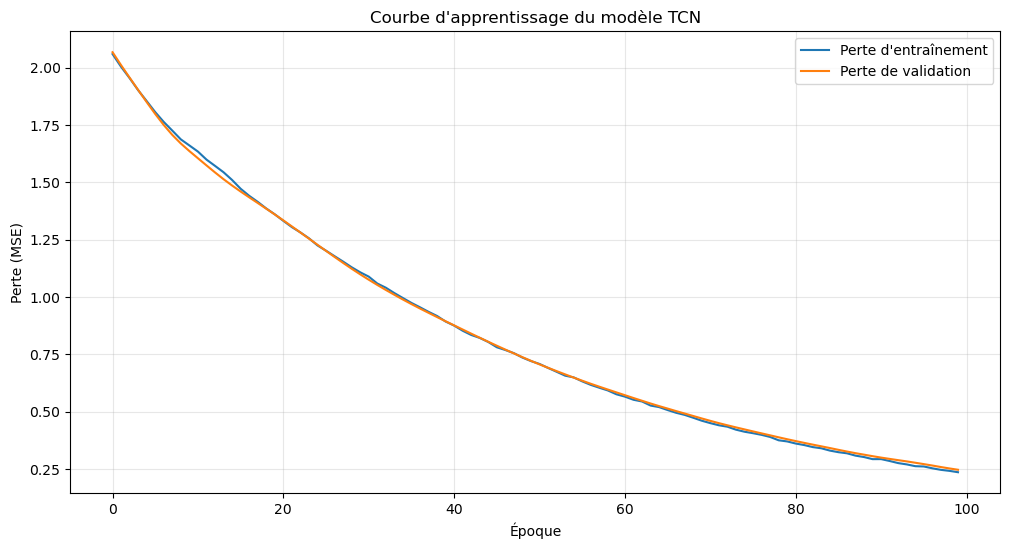

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


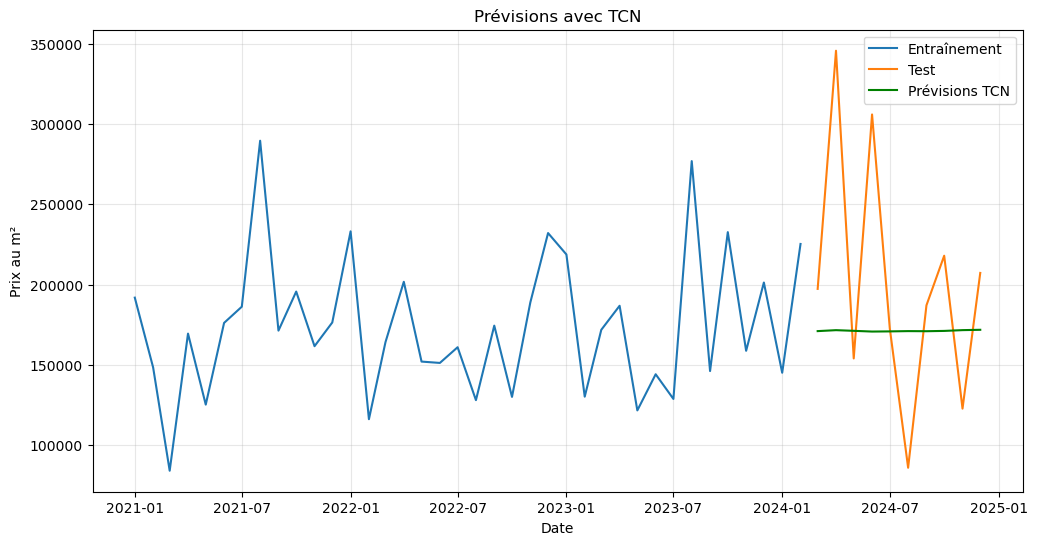


Évaluation du modèle TCN:
MAE: 58699.07
RMSE: 79311.53
MAPE: 30.62%


(58699.071447103095, 79311.53396865833, 30.624177598969897)

In [172]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.regularizers import l2

# Création d'un modèle TCN simplifié
def create_tcn_model(input_shape):
    model = Sequential([
        # Couches de convolution 1D avec dilatation croissante
        Conv1D(filters=64, kernel_size=2, dilation_rate=1, activation='relu', 
               input_shape=input_shape, padding='causal', kernel_regularizer=l2(0.01)),
        Conv1D(filters=64, kernel_size=2, dilation_rate=2, activation='relu', 
               padding='causal', kernel_regularizer=l2(0.01)),
        Conv1D(filters=64, kernel_size=2, dilation_rate=4, activation='relu', 
               padding='causal', kernel_regularizer=l2(0.01)),
        Conv1D(filters=64, kernel_size=2, dilation_rate=8, activation='relu', 
               padding='causal', kernel_regularizer=l2(0.01)),
        
        # Global pooling
        MaxPooling1D(pool_size=2),
        
        # Couches denses
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Création du modèle TCN
tcn_model = create_tcn_model((seq_length, 1))
tcn_model.summary()

# Entraînement du modèle
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_tcn = tcn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Visualisation de la courbe d'apprentissage
plt.figure(figsize=(12, 6))
plt.plot(history_tcn.history['loss'], label='Perte d\'entraînement')
plt.plot(history_tcn.history['val_loss'], label='Perte de validation')
plt.title('Courbe d\'apprentissage du modèle TCN')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Prévisions
y_pred_tcn_scaled = tcn_model.predict(X_test)

# Inverse de la normalisation
y_pred_tcn = scaler.inverse_transform(y_pred_tcn_scaled)

# Visualisation des prévisions
plt.figure(figsize=(12, 6))
plt.plot(monthly_prices.index[seq_length:train_size+seq_length], scaler.inverse_transform(y_train), label='Entraînement')
plt.plot(monthly_prices.index[train_size+seq_length:], y_test_actual, label='Test')
plt.plot(monthly_prices.index[train_size+seq_length:], y_pred_tcn, label='Prévisions TCN', color='green')
plt.title('Prévisions avec TCN')
plt.xlabel('Date')
plt.ylabel('Prix au m²')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Évaluation du modèle
print("\nÉvaluation du modèle TCN:")
evaluate_model(y_test_actual.flatten(), y_pred_tcn.flatten())

In [19]:
df_train = df_dep[df_dep['annee'] < 2024]
df_test = df_dep[df_dep['annee'] == 2024]

X_train = df_train.drop(['prix_m2_vente'], axis=1)
X_test = df_test.drop(['prix_m2_vente'], axis=1)

y_train = df_train['prix_m2_vente'].values.reshape(-1, 1)
y_test = df_test['prix_m2_vente'].values.reshape(-1, 1)

In [21]:
one_hot_cols = ['type_local', 'nature_mutation']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(X_train[one_hot_cols])

X_train_ohe = pd.DataFrame(ohe.transform(X_train[one_hot_cols]), 
                           columns=ohe.get_feature_names_out(one_hot_cols),
                           index=X_train.index)

X_test_ohe = pd.DataFrame(ohe.transform(X_test[one_hot_cols]), 
                          columns=ohe.get_feature_names_out(one_hot_cols),
                          index=X_test.index)

X_train = X_train.drop(columns=one_hot_cols)
X_test = X_test.drop(columns=one_hot_cols)

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)

freq_cols = ['code_nature_culture', 'code_nature_culture_speciale', 'code_commune', 'code_departement']

for col in freq_cols:
    freq_encoding = X_train[col].value_counts(normalize=True)

    X_train[col] = X_train[col].map(freq_encoding).fillna(0)
    X_test[col] = X_test[col].map(freq_encoding).fillna(0)


X_train['lot1_numero'] = (X_train['lot1_numero'] != 0).astype(int)
X_test['lot1_numero'] = (X_test['lot1_numero'] != 0).astype(int)

print("Variables catégorielles restantes :", len(X_train.select_dtypes('object').columns))

Variables catégorielles restantes : 0


In [23]:
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)

In [27]:
robust_x_scaler = RobustScaler()
X_train_scaled = robust_x_scaler.fit_transform(X_train)
X_test_scaled = robust_x_scaler.transform(X_test)

robust_y_scaler = RobustScaler()
y_train_scaled = robust_y_scaler.fit_transform(y_train)
y_test_scaled = robust_y_scaler.transform(y_test)

TypeError: float() argument must be a string or a real number, not 'Period'

In [25]:
from tensorflow.keras.optimizers import AdamW

timesteps = 12

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps=timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps=timesteps)

train_set = tf.data.Dataset.from_tensor_slices((X_train_seq, y_train_seq)).batch(16)
test_set = tf.data.Dataset.from_tensor_slices((X_test_seq, y_test_seq)).batch(16)

model_rnn = Sequential([
    Input(shape=(timesteps, X_train_scaled.shape[1])),
    
    Bidirectional(LSTM(128, return_sequences=True, activation="tanh")),  # Capture les tendances avant/arrière
    Dropout(0.2),

    Bidirectional(GRU(64, return_sequences=True, activation="tanh")),  # GRU bidirectionnel
    Dropout(0.2),
    
    GRU(32, return_sequences=False, activation="tanh"),
    Dropout(0.2),

    Dense(16, activation="relu"),
    Dense(1)
])

model_rnn.compile(
    loss="mse",
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
    metrics=["mae"]
)

history = model_rnn.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])
y_pred_rnn = model_rnn.predict(X_test_seq)

NameError: name 'X_train_scaled' is not defined

---

In [145]:
scaler_y = robust_y_scaler
display_scores(y_test_seq, y_pred_rnn, 'RNN', 'robust')

,Modèle,Scaler,MAE,RMSE,R2
0,RNN,robust,126459.016422,174482.246974,0.371986


In [159]:
from tensorflow.keras.layers import Add, GlobalAveragePooling1D

input_layer = Input(shape=(timesteps, X_train_scaled.shape[1]))
x = Bidirectional(LSTM(128, return_sequences=True, activation="tanh"))(input_layer)
x = GRU(64, return_sequences=True, activation="tanh")(x)

residual = x  
x = LSTM(32, return_sequences=True, activation="tanh")(x)

residual = GlobalAveragePooling1D()(residual)
x = GlobalAveragePooling1D()(x)

residual = Dense(32, activation="tanh")(residual)
x = Add()([x, residual]) 

output_layer = Dense(1)(x)

model_rnn = Model(inputs=input_layer, outputs=output_layer)

model_rnn.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
    metrics=["mae"]
)

history = model_rnn.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])
y_pred_rnn = model_rnn.predict(X_test_seq)

Epoch 1/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.7217 - mae: 0.5991 - val_loss: 0.7307 - val_mae: 0.5645 - learning_rate: 0.0010
Epoch 2/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5987 - mae: 0.5309 - val_loss: 0.7215 - val_mae: 0.6203 - learning_rate: 0.0010
Epoch 3/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6025 - mae: 0.5262 - val_loss: 0.7351 - val_mae: 0.5718 - learning_rate: 0.0010
Epoch 4/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6085 - mae: 0.5276 - val_loss: 0.6619 - val_mae: 0.5823 - learning_rate: 0.0010
Epoch 5/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5717 - mae: 0.5072 - val_loss: 0.6830 - val_mae: 0.5605 - learning_rate: 0.0010
Epoch 6/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5686 - mae: 0.5058 - val_loss: 0.7119 - val_mae: 0.5687 - learning_rate: 0.0010
Epoch 7/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5544 - mae: 0.4981 - val_loss: 0.7606 - val_mae: 0.5913 - learning_rate: 0.001

In [163]:
scaler_y = robust_y_scaler
display_scores(y_test_seq, y_pred_rnn, 'RNN + residu', 'robust')

,Modèle,Scaler,MAE,RMSE,R2
0,RNN,robust,125476.100855,175297.990699,0.3661


In [173]:
!pip install keras-tcn

In [78]:
from tensorflow.keras.optimizers import Adam
from tcn import TCN

timesteps = 12
features = X_train_scaled.shape[1]

input_layer = Input(shape=(timesteps, features))
x = TCN(nb_filters=128, kernel_size=3, dilations=[1, 2, 4, 8, 16, 32], activation="relu")(input_layer)
x = Dropout(0.2)(x)
x = Dense(32, activation="linear")(x)
output_layer = Dense(1)(x)

model_tcn = Model(inputs=input_layer, outputs=output_layer)
model_tcn.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.0005),
    metrics=["mae"]
)

model_tcn.summary()

history = model_tcn.fit(
    X_train_seq, y_train_seq, 
    epochs=10, batch_size=32, 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[callbacks]
)

y_pred_tcn = model_tcn.predict(X_test_seq)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 12, 29)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tcn_1 (TCN)                          │ (None, 128)                 │         557,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 561,345 (2.14 MB)

 Trainable params: 561,345 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 134s 28ms/step - loss: 276.0675 - mae: 3.6717 - val_loss: 58.5097 - val_mae: 1.4596 - learning_rate: 5.0000e-04
Epoch 2/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 141s 31ms/step - loss: 63.3451 - mae: 1.7076 - val_loss: 61.6891 - val_mae: 1.3242 - learning_rate: 5.0000e-04
Epoch 3/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 139s 31ms/step - loss: 47.6810 - mae: 1.4851 - val_loss: 55.0000 - val_mae: 1.3302 - learning_rate: 5.0000e-04
Epoch 4/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 130s 29ms/step - loss: 50.0570 - mae: 1.4244 - val_loss: 56.2843 - val_mae: 1.2456 - learning_rate: 5.0000e-04
Epoch 5/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 129s 28ms/step - loss: 46.7267 - mae: 1.3805 - val_loss: 53.9714 - val_mae: 1.2273 - learning_rate: 5.0000e-04
Epoch 6/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 130s 28ms/step - loss: 46.5217 - mae: 1.3606 - val_loss: 54.6473 - val_mae: 1.1968 - learning_rate: 5.0000e-04
Epoch 7/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 130s 29ms/step - loss: 41.5324 - mae: 1

In [80]:
scaler_y = robust_y_scaler
display_scores(y_test_seq, y_pred_tcn, 'TCN', 'robust')

,Modèle,Scaler,MAE,RMSE,R2
0,TCN,robust,2582.952873,15004.88812,0.161125
